# Lab 5

## Setup

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import accuracy_score

# Common imports
import numpy as np
import os

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Save figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Get the data

### Download the data

In [6]:
import os
import tarfile
import urllib.request

In [7]:
import pandas as pd

def load_neo_data(neo_path='.'):
    csv_path = os.path.join(neo_path, "neo.csv")
    return pd.read_csv(csv_path)

### Take a quick look at the structure

In [8]:
neo = load_neo_data()
neo.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [9]:
neo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [10]:
neo["orbiting_body"].value_counts()

orbiting_body
Earth    90836
Name: count, dtype: int64

> Notice: all the data is present.

In [11]:
neo["hazardous_int"] = neo["hazardous"].astype("int")
neo = neo.drop("hazardous", axis=1)
neo.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_int
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000


Saving figure attr_histograms


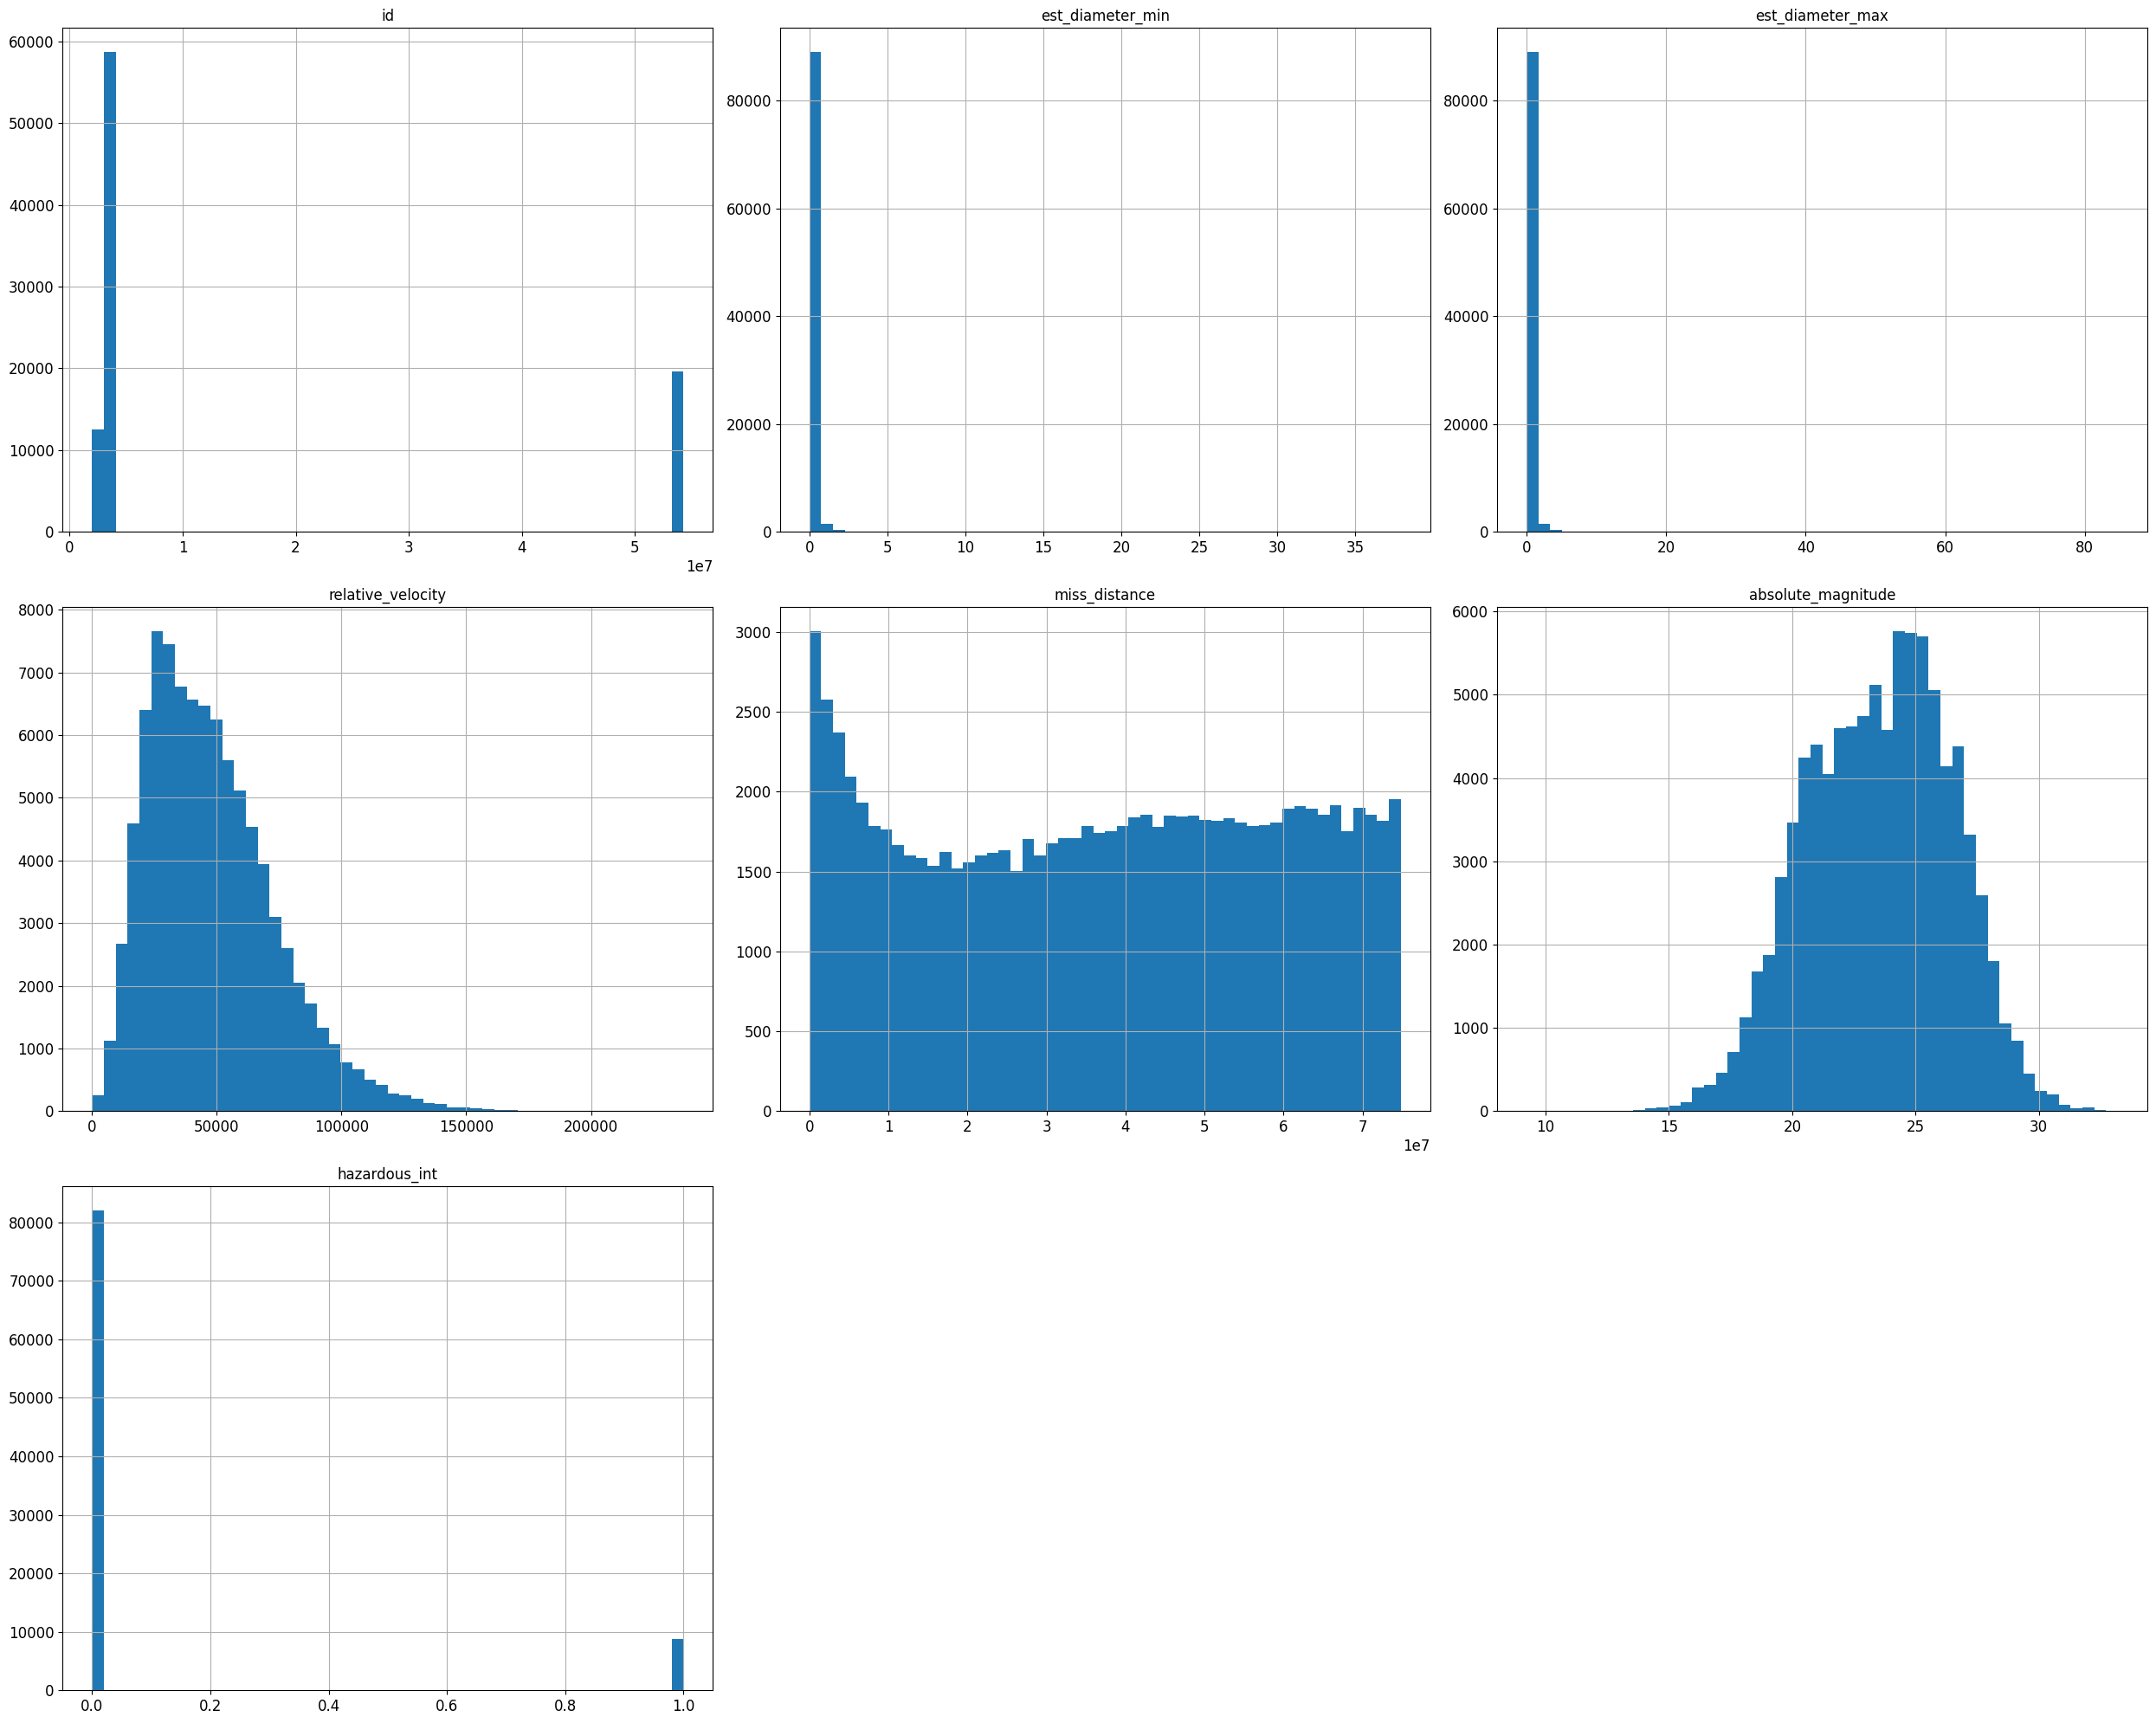

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
neo.hist(bins=50, figsize=(25,20))
save_fig("attr_histograms")
plt.show()

## Create a test set

In [13]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [14]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [15]:
train_set, test_set = split_train_test(neo, 0.2)
len(train_set)

72669

In [16]:
len(test_set)

18167

In [17]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [18]:
neo["orbiting_body"].value_counts()

orbiting_body
Earth    90836
Name: count, dtype: int64

In [19]:
neo["sentry_object"].value_counts()

sentry_object
False    90836
Name: count, dtype: int64

> Remove columns with equal values

In [20]:
neo = neo.drop("orbiting_body", axis=1)
neo = neo.drop("sentry_object", axis=1)
neo = neo.drop("name", axis=1)
neo = neo.drop("id", axis=1)

In [21]:
neo.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_int
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1


In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(neo, test_size=0.2, random_state=42)

In [23]:
test_set.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_int
20406,0.024241,0.054205,22148.962596,5.028574e+07,25.20,0
74443,0.012722,0.028447,26477.211836,1.683201e+06,26.60,0
74306,0.013322,0.029788,33770.201397,3.943220e+06,26.50,0
45943,0.193444,0.432554,43599.575296,7.346837e+07,20.69,0
62859,0.044112,0.098637,36398.080883,6.352916e+07,23.90,0


<Axes: >

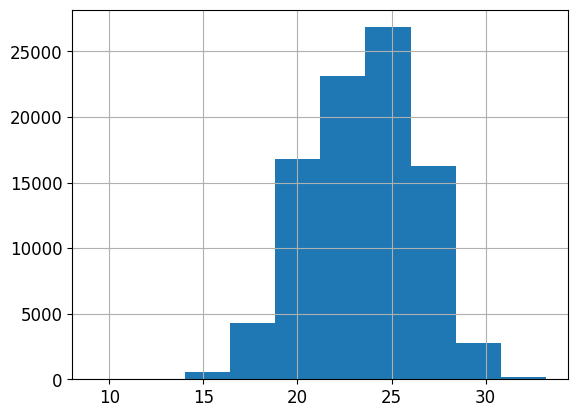

In [24]:
neo["absolute_magnitude"].hist()

In [25]:
neo["magnitude_cat"] = pd.cut(neo["absolute_magnitude"],
                               bins=[0, 15, 20, 25, 30, np.inf],
                               labels=[1, 2, 3, 4, 5])

In [26]:

neo["magnitude_cat"].value_counts()

magnitude_cat
3    49394
4    29553
2    11257
5      530
1      102
Name: count, dtype: int64

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(neo, neo["magnitude_cat"]):
    strat_train_set = neo.loc[train_index]
    strat_test_set = neo.loc[test_index]

In [28]:
strat_test_set["magnitude_cat"].value_counts() / len(strat_test_set)

magnitude_cat
3    0.543758
4    0.325352
2    0.123954
5    0.005834
1    0.001101
Name: count, dtype: float64

In [29]:
neo["magnitude_cat"].value_counts() / len(neo)

magnitude_cat
3    0.543771
4    0.325345
2    0.123927
5    0.005835
1    0.001123
Name: count, dtype: float64

In [30]:
from sklearn.model_selection import train_test_split

def income_cat_proportions(data):
    return data["magnitude_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(neo, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(neo),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [31]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
magnitude_cat,,,,,
1,0.001123,0.001101,0.001211,7.838389,-1.965101
2,0.123927,0.123954,0.124945,0.821713,0.022246
3,0.543771,0.543758,0.544309,0.098844,-0.002379
4,0.325345,0.325352,0.324031,-0.403668,0.002364
5,0.005835,0.005834,0.005504,-5.664531,-0.004403


In [32]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("magnitude_cat", axis=1, inplace=True)

In [33]:
neo.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_int,magnitude_cat
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0,2
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1,2
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0,2
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0,3
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1,3


## Discover and visualize data to gain insights

In [34]:
neo = strat_train_set.copy()

Saving figure objects_velocity_scatterplot


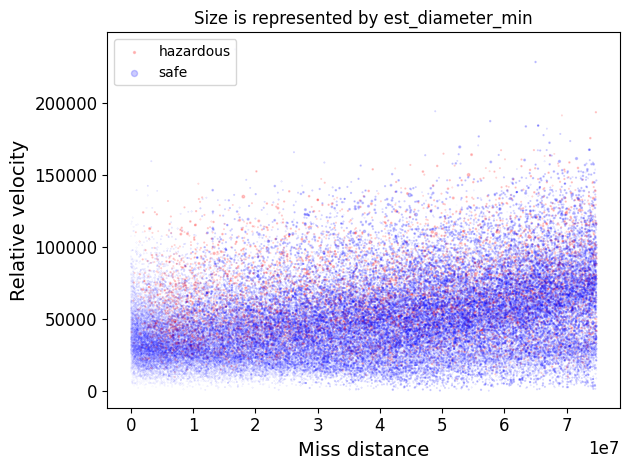

In [35]:
hazardous = neo[neo["hazardous_int"] == 1]
safe = neo[neo["hazardous_int"] == 0]

plt.scatter(hazardous["miss_distance"], hazardous["relative_velocity"], alpha=0.2,
             s=hazardous["est_diameter_min"], label="hazardous", c="red")

plt.scatter(safe["miss_distance"], safe["relative_velocity"], alpha=0.2,
             s=safe["est_diameter_min"], label="safe", c="blue")

plt.title("Size is represented by est_diameter_min")
plt.xlabel("Miss distance")
plt.ylabel("Relative velocity")
plt.legend(loc='upper left')
save_fig("objects_velocity_scatterplot")

Saving figure scatter_matrix_plot


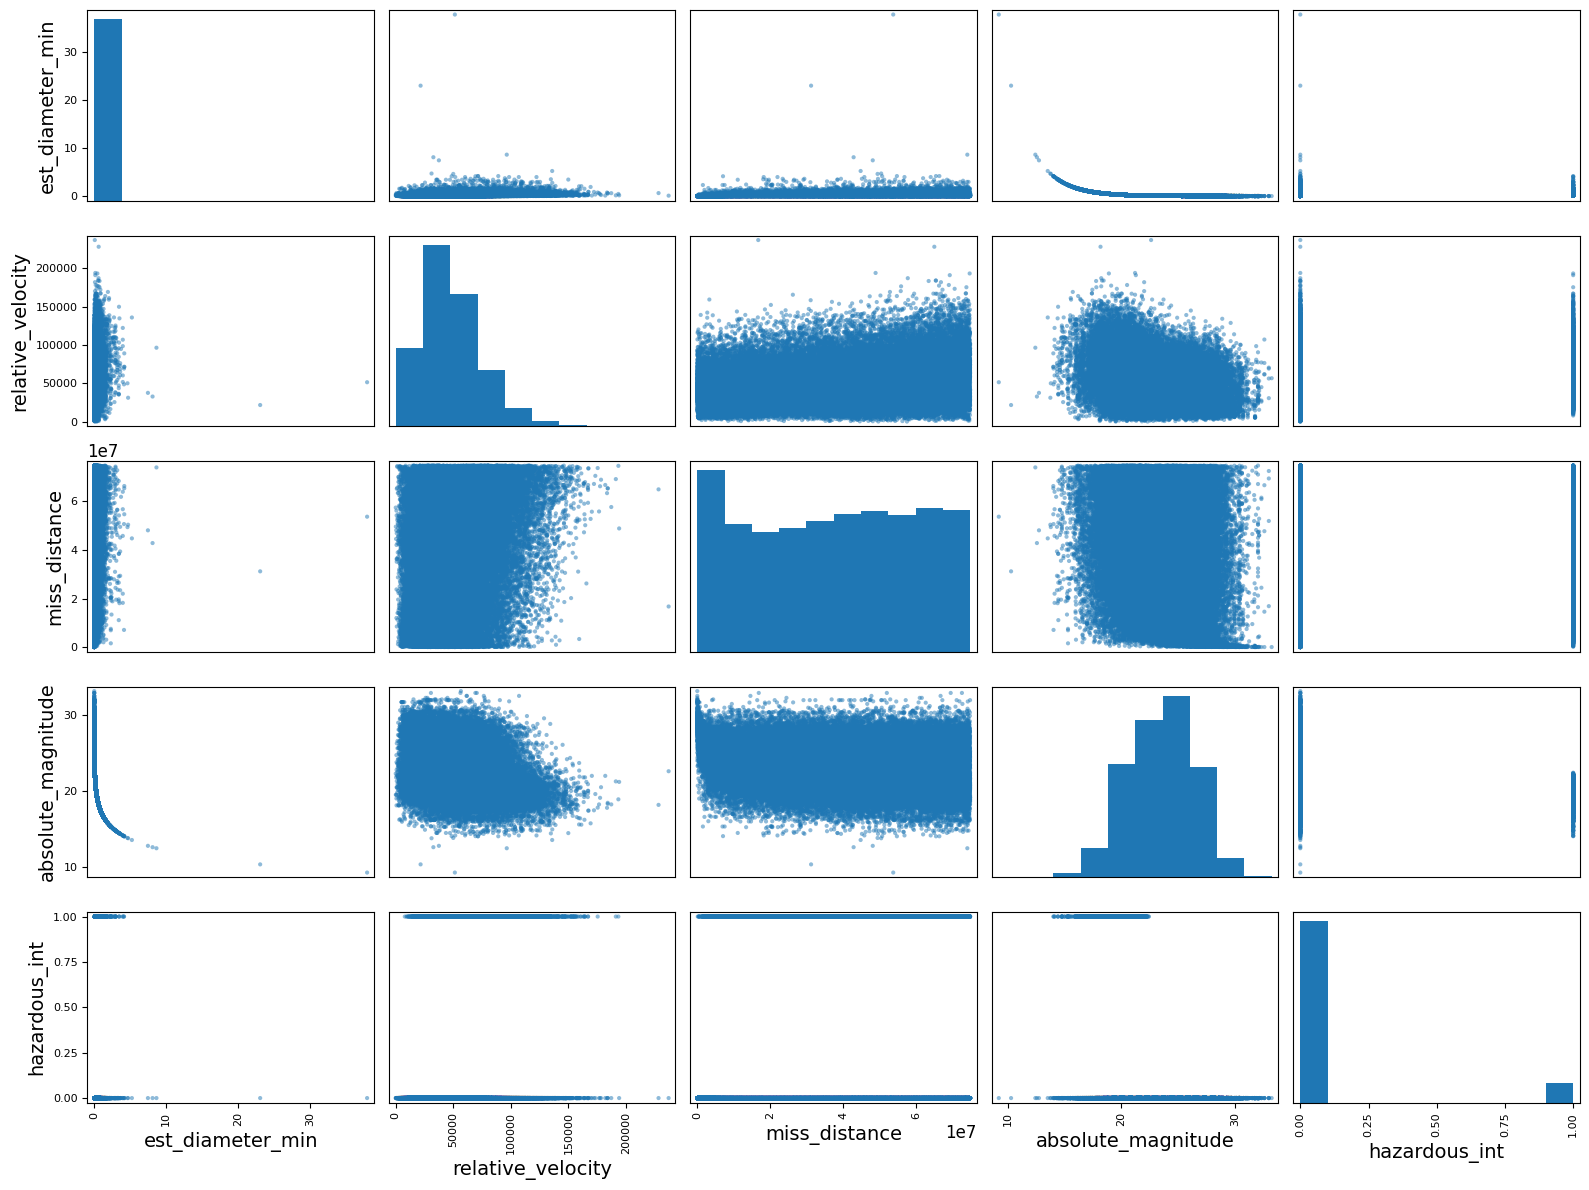

In [36]:
from pandas.plotting import scatter_matrix

attributes = ["est_diameter_min", "relative_velocity",
              "miss_distance", "absolute_magnitude", "hazardous_int"]
scatter_matrix(neo[attributes], figsize=(16, 12))
save_fig("scatter_matrix_plot")

In [37]:
neo.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_int
18944,0.040046,0.089545,19223.450008,2.978361e+07,24.11,0
5137,0.009174,0.020514,25865.326186,6.606667e+07,27.31,0
63954,0.402305,0.899580,113670.734376,2.180891e+07,19.10,1
7029,0.005065,0.011325,34158.861123,4.308023e+07,28.60,0
72039,0.013322,0.029788,30089.793851,3.392224e+06,26.50,0


### Looking for correlations

In [38]:
corr_matrix = neo.corr()
corr_matrix["hazardous_int"].sort_values(ascending=False)

hazardous_int         1.000000
est_diameter_max      0.192236
est_diameter_min      0.192236
relative_velocity     0.189144
miss_distance         0.040979
absolute_magnitude   -0.364857
Name: hazardous_int, dtype: float64

## Prepare the data for ML algorithms

In [39]:
neo = strat_train_set.drop("hazardous_int", axis=1)
neo_labels = strat_train_set["hazardous_int"].copy()

### Transformation pipelines

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

neo_prepared = full_pipeline.fit_transform(neo)

In [41]:
neo_prepared.shape

(72668, 5)

In [42]:
neo_prepared = full_pipeline.fit_transform(neo)

## Select and train a model

### Training and Evaluating on the Training set

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

kn_classifier = KNeighborsClassifier()
kn_classifier.fit(neo_prepared, neo_labels)

KNeighborsClassifier()

In [44]:
some_data = neo.iloc[:5]
some_labels = neo_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", kn_classifier.predict(some_data_prepared))

Predictions: [0 0 1 0 0]


In [45]:
print("Labels:", list(some_labels))

Labels: [0, 0, 1, 0, 0]


In [46]:
some_data_prepared

array([[-0.30432745, -0.30432745, -1.14253852, -0.32747357,  0.20080095],
       [-0.41253718, -0.41253718, -0.88004995,  1.29635168,  1.30658897],
       [ 0.96544231,  0.96544231,  2.59004118, -0.68437646, -1.53044842],
       [-0.42694053, -0.42694054, -0.55228743,  0.26760792,  1.75235976],
       [-0.39799912, -0.39799912, -0.71309796, -1.50860374,  1.02668637]])

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

neo_predictions = kn_classifier.predict(neo_prepared)
kn_mse = mean_squared_error(neo_labels, neo_predictions)
kn_rmse = np.sqrt(kn_mse)
print("KN RMSE: ", kn_rmse)
print("Confussion matrix:\n", confusion_matrix(neo_labels, neo_predictions), "\n")
print("Classification report:\n", classification_report(neo_labels, neo_predictions))

KN RMSE:  0.2631210265824898
Confussion matrix:
 [[64347  1270]
 [ 3761  3290]] 

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     65617
           1       0.72      0.47      0.57      7051

    accuracy                           0.93     72668
   macro avg       0.83      0.72      0.76     72668
weighted avg       0.92      0.93      0.92     72668



In [48]:
kn_accuracy = accuracy_score(neo_labels, neo_predictions)*100

print(f"Accuracy of KN Classifier = {kn_accuracy}")

Accuracy of KN Classifier = 93.07673253701768


In [49]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(neo_prepared, neo_labels)

DecisionTreeClassifier(random_state=42)

In [50]:
neo_predictions = tree_classifier.predict(neo_prepared)

tree_mse = mean_squared_error(neo_labels, neo_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Tree RMSE: ", tree_rmse)
print("Confussion matrix:\n", confusion_matrix(neo_labels, neo_predictions), "\n")
print("Classification report:\n", classification_report(neo_labels, neo_predictions))

Tree RMSE:  0.0
Confussion matrix:
 [[65617     0]
 [    0  7051]] 

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65617
           1       1.00      1.00      1.00      7051

    accuracy                           1.00     72668
   macro avg       1.00      1.00      1.00     72668
weighted avg       1.00      1.00      1.00     72668



In [51]:
tree_accuracy = accuracy_score(neo_labels, neo_predictions)*100

print(f"Accuracy of Decision Tree Classifier = {tree_accuracy}")

Accuracy of Decision Tree Classifier = 100.0


### Better evaluating using cross-validation

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_classifier, neo_prepared, neo_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [53]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [0.33468375 0.32232641 0.32845846 0.33386042 0.32866787 0.32381719
 0.33856723 0.33054658 0.32701134 0.322562  ]
Mean: 0.3290501247962756
Standard deviation: 0.005167511466959828


In [54]:
kn_scores = cross_val_score(kn_classifier, neo_prepared, neo_labels,
                             scoring="neg_mean_squared_error", cv=10)
kn_rmse_scores = np.sqrt(-kn_scores)
display_scores(kn_rmse_scores)

Scores: [0.31737883 0.31737883 0.31323277 0.31824481 0.30769231 0.31454795
 0.3167278  0.31585767 0.32106518 0.3163148 ]
Mean: 0.3158440950652136
Standard deviation: 0.003371755734316293


In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
forest_classifier.fit(neo_prepared, neo_labels)

RandomForestClassifier(random_state=42)

In [56]:
neo_predictions = forest_classifier.predict(neo_prepared)

forest_mse = mean_squared_error(neo_labels, neo_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Forest RMSE: ", forest_rmse)
print("Confussion matrix:\n", confusion_matrix(neo_labels, neo_predictions), "\n")
print("Classification report:\n", classification_report(neo_labels, neo_predictions))

Forest RMSE:  0.0
Confussion matrix:
 [[65617     0]
 [    0  7051]] 

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     65617
           1       1.00      1.00      1.00      7051

    accuracy                           1.00     72668
   macro avg       1.00      1.00      1.00     72668
weighted avg       1.00      1.00      1.00     72668



In [57]:
forest_accuracy = accuracy_score(neo_labels, neo_predictions)*100

print(f"Accuracy of Random Forest Classifier = {forest_accuracy}")

Accuracy of Random Forest Classifier = 100.0


In [58]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_classifier, neo_prepared, neo_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.29676481 0.28251169 0.28686199 0.29020048 0.28129133 0.28638189
 0.29815265 0.2817801  0.29022045 0.28688173]
Mean: 0.2881047135553726
Standard deviation: 0.005554638215131792


In [59]:
scores = cross_val_score(kn_classifier, neo_prepared, neo_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count    10.000000
mean      0.315844
std       0.003554
min       0.307692
25%       0.314875
50%       0.316521
75%       0.317379
max       0.321065
dtype: float64

## Fine-tune your model

### Grid search

In [60]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_classifier = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of 6*5=30 rounds of training 
grid_search = GridSearchCV(forest_classifier, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(neo_prepared, neo_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [61]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 10}

In [62]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_features=2, n_estimators=10,
                       random_state=42)

In [63]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.315871,0.008846,0.007059,0.000639,False,2,3,"{'bootstrap': False, 'max_features': 2, 'n_est...",-0.095431,-0.097771,...,-0.096576,0.000838,3,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
1,1.037128,0.031634,0.018329,0.001162,False,2,10,"{'bootstrap': False, 'max_features': 2, 'n_est...",-0.089170,-0.091303,...,-0.089930,0.001263,1,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
2,0.444791,0.012457,0.006212,0.000608,False,3,3,"{'bootstrap': False, 'max_features': 3, 'n_est...",-0.099835,-0.102449,...,-0.100966,0.001035,5,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
3,1.526934,0.021250,0.017765,0.000248,False,3,10,"{'bootstrap': False, 'max_features': 3, 'n_est...",-0.092954,-0.094055,...,-0.093163,0.001680,2,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
4,0.580984,0.013928,0.006140,0.000200,False,4,3,"{'bootstrap': False, 'max_features': 4, 'n_est...",-0.100936,-0.104101,...,-0.103966,0.001643,6,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
5,1.850435,0.018766,0.016757,0.000512,False,4,10,"{'bootstrap': False, 'max_features': 4, 'n_est...",-0.097977,-0.100110,...,-0.097319,0.001757,4,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0


### Randomized search

In [64]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=10, high=200),
        'max_features': randint(low=1, high=5),
    }

forest_classifier = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_classifier, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(neo_prepared, neo_labels)

KeyboardInterrupt: 

### Analyze the Best Models and Their Errors

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
attributes = list(neo)
sorted(zip(feature_importances, attributes), reverse=True)

### Evaluate Your System on the Test Set

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("hazardous_int", axis=1)
y_test = strat_test_set["hazardous_int"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Final RMSE: ", final_rmse)
print("Confussion matrix:\n", confusion_matrix(y_test, final_predictions), "\n")
print("Classification report:\n", classification_report(y_test, final_predictions))

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)